# Image classification between muffins and chihuahuas using Keras with hyperparameter optimization

- Juan Fernando Martínez H.
- Diana Sofía Olano

## 0. Dataset

Obtained from Kaggle: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/code?datasetId=2733586&sortBy=voteCount

## 1. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

2023-10-14 03:00:35.828422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 03:00:35.870588: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 03:00:35.870630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 03:00:35.870654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 03:00:35.878225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 03:00:35.879023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## 2. Dataset preparation

### 2.1. Train, val, test split and image size reduction

The keras library provides the function keras.utils.image_dataset_from_directory() that loads the images from disk and stores them on a tensorflow.data.Dataset object.

In [2]:
train_set, val_set = keras.utils.image_dataset_from_directory(  'c-vs-m/train',
                                                                image_size=(100, 100),
                                                                shuffle=True, seed=123,
                                                                validation_split=0.25,
                                                                subset="both")
test_set = keras.utils.image_dataset_from_directory('c-vs-m/test',
                                                    image_size=(100, 100),
                                                    shuffle=True,seed=123)

Found 4402 files belonging to 2 classes.
Using 3302 files for training.
Using 1100 files for validation.
Found 1183 files belonging to 2 classes.


The Dataset stores the images and the labels on batches of 32 elements. An element is a tuple where position 0 holds an array of the images and position 1 has the labels. On the output from the cell below there are 32 labels for 32 images of shape 80x80x3. Label 0 represents chihuahuas and label 1 muffins.

In [3]:
train_set_element = train_set.as_numpy_iterator().next() # Can also be iterated using a for each loop: for element in set, for data,label in set

print('Labels: ', train_set_element[1])
print('Images shape: ',train_set_element[0].shape)

Labels:  [0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
Images shape:  (32, 100, 100, 3)


### 2.2 Sample images

In the following code snippet a sample image from the train set is displayed that also shows the numerical label and class.

Its a [1] muffin


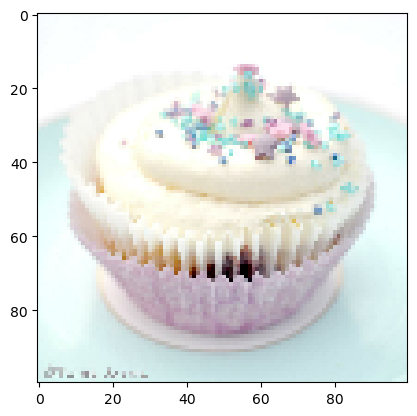

In [4]:
#Gets a random batch from the train set 
sample_image = train_set.as_numpy_iterator().next()

#Extracts data and label
data = sample_image[0][30]
label = sample_image[1][30]

#Displays the image and its label
plt.imshow(data.astype(int))
print("Its a", '['+str(label)+']', 'muffin' if label==1 else 'chihuahua')

### 2.3 Convert Dataset object to numpy arrays

This conversion despite not mandatory we prefered to do it because of initial problems with keras Normalization layer, that gave accuracy results lower than randomly choosing the label.

In [5]:
def dataset_to_numpy(dataset):
    # Crear un iterador a partir del conjunto de datos
    iterator = dataset.as_numpy_iterator()

    # Obtener el primer lote
    batch = iterator.next()
    data_x = batch[0]
    data_y = batch[1]

    # Iterar a través de los lotes restantes
    for batch in iterator:
        images = batch[0]
        labels = batch[1]

        # Concatenar los datos de los lotes
        data_x = np.concatenate((data_x, images))
        data_y = np.concatenate((data_y, labels))

    # Reformatear las etiquetas si es necesario
    data_y = data_y.reshape((-1, 1))

    return data_x, data_y

In [6]:
train_set_x, train_set_y = dataset_to_numpy(train_set)
val_set_x, val_set_y = dataset_to_numpy(val_set)
test_set_x, test_set_y = dataset_to_numpy(test_set)

In [7]:
print("Train Data Shape:", train_set_x.shape)
print("Train Labels Shape:", train_set_y.shape)
print("Validation Data Shape:" ,val_set_x.shape)
print("Validation Labels Shape:", val_set_y.shape)
print("Test Data Shape:", test_set_x.shape)
print("Test Labels Shape:",test_set_y.shape)

Train Data Shape: (3302, 100, 100, 3)
Train Labels Shape: (3302, 1)
Validation Data Shape: (1100, 100, 100, 3)
Validation Labels Shape: (1100, 1)
Test Data Shape: (1183, 100, 100, 3)
Test Labels Shape: (1183, 1)


### 2.4 Image flattening and normalization
The function is responsible for transforming the image data by flattening and normalizing it so that it is in a more manageable format and with a consistent scale for training it in the machine learning model.

In [8]:
def flatten_and_normalize_image_data(data):
    # Aplanar las imágenes: Rearrangement de los datos de color de píxel de cada imagen en una matriz unidimensional
    data_flatten = data.reshape(data.shape[0], -1).T
    
    # Normalizar los datos dividiendo los valores de píxeles para que estén en el rango entre 0 y 1.
    data_normalized = data_flatten / 255.
    
    return data_normalized

In [9]:
train_set_x = flatten_and_normalize_image_data(train_set_x).T
test_set_x = flatten_and_normalize_image_data(test_set_x).T
val_set_x = flatten_and_normalize_image_data(val_set_x).T

print(train_set_x.shape)
print(val_set_x.shape)
print(test_set_x.shape)

(3302, 30000)
(1100, 30000)
(1183, 30000)


## 3. Model training and hyperparameter optimization

### 3.0.1 Function for training models

In [10]:
def create_train_model(learning_rate=0.01, num_layers = 1, num_neurons = 64, early_stop_active = False, patience=6, activation_fun="sigmoid",optimizer_name="SGD", verbose = 0, epochs=40):
    image_shape = train_set_x[0].shape
    
    # Compilar el modelo con el optimizador dado
    optimizer = None
    if optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD()
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam()
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop()

    # Crear un modelo secuencial    
    model = keras.Sequential()
    model.add(keras.Input(shape=image_shape))#Input layer
    #Add a normalization layer
  #model.add(keras.layers.Normalization())
  #Add a flattening layer
  #model.add(keras.layers.Flatten())


    for i in range(num_layers):
        model.add(keras.layers.Dense(units=num_neurons, activation=activation_fun))  
    
    model.add(keras.layers.Dense(1, activation="sigmoid")) #Output layer
    
    class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

    early_stop = None
    callbacks = None
    if(early_stop_active):
      early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
      callbacks=[early_stop, PrintDot()]
    else:
      callbacks = []

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    if (verbose == 1):
      model.summary()

    # Entrenar el modelo
    history = model.fit(x=train_set_x, y=train_set_y, validation_data=(val_set_x, val_set_y), verbose=verbose, epochs=epochs,callbacks=callbacks,shuffle=False)

    return history,model

#https://keras.io/api/layers/reshaping_layers/flatten/ and https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
#https://towardsai.net/p/l/impact-of-optimizers-in-image-classifiers
    

### 3.0.2 Function for plotting basic graph

In [11]:
def graph(x,y,labels,x_label,y_label, title):

    for i in range(len(y)):
        plt.plot(x, y[i], label=labels[i])

    # Add labels to the x- and y-axis of the plot
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Add a title to the graph
    plt.title(title)

    # Display a legend to indicate which line represents which data set
    plt.legend()

    # Enable a grid on the graph
    plt.grid(True)

    # Show the graph
    plt.show()

### 3.1 Base model
Base model starting with simple network. 1 hidden layer, 64 neurons, gradient descent optimizer, sigmoid activation functions and binary_crossentropy loss.

#### Train

In [12]:
history_base = create_train_model()[0]

In [13]:
epochs = history_base.epoch
train_loss_history = history_base.history['loss']
val_loss_history = history_base.history['val_loss']

train_acc_history = history_base.history['accuracy']
val_acc_history = history_base.history['val_accuracy']

#### Accuracy and loss vs epochs

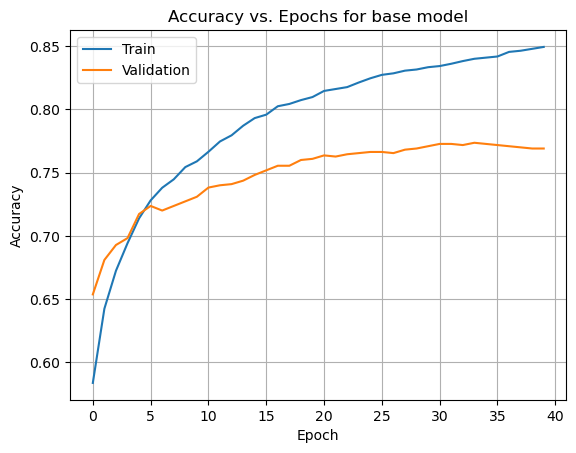

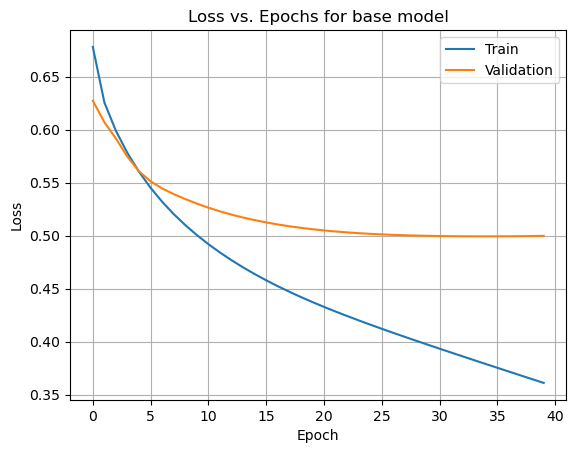

In [14]:
graph(epochs,[train_acc_history,val_acc_history],['Train','Validation'],'Epoch','Accuracy','Accuracy vs. Epochs for base model')
graph(epochs,[train_loss_history,val_loss_history],['Train','Validation'],'Epoch','Loss','Loss vs. Epochs for base model')

### 3.1 Optimizer

Training for SGD
Training for Adam
Training for RMSprop


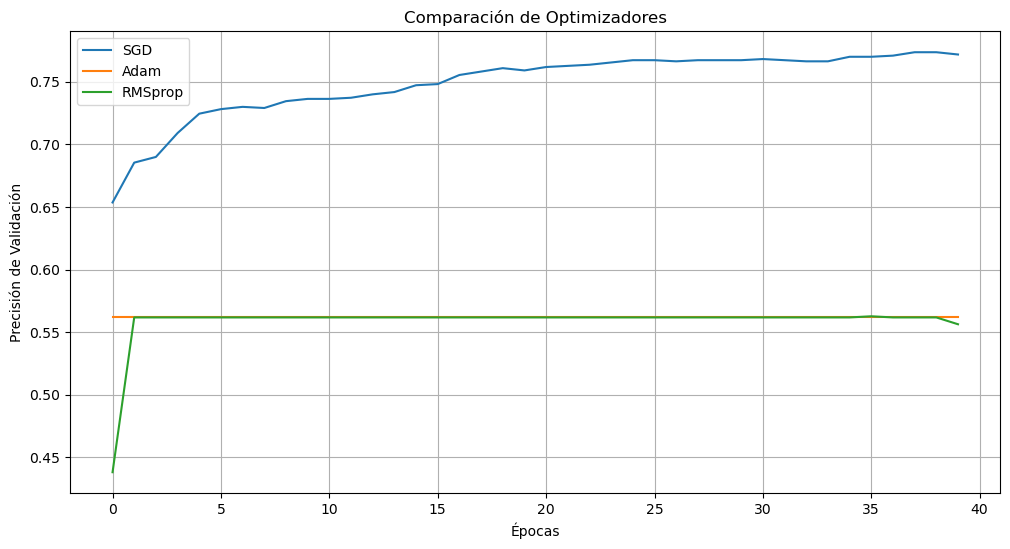

In [15]:
#GRÁFICA

# Lista de nombres de optimizadores a probar
optimizers = ['SGD', 'Adam', 'RMSprop']

#Entrenar modelos con diferentes optimizadores y guardar el historial
histories = {}

for optimizer_name in optimizers:
    print("Training for", optimizer_name)
    history = create_train_model(optimizer_name=optimizer_name)[0]    
    histories[optimizer_name] = history

# Graficar las curvas de aprendizaje para comparar los desempeños
plt.figure(figsize=(12, 6))

for optimizer_name, history in histories.items():
    plt.plot(history.epoch,np.array(history.history['val_accuracy']), label=optimizer_name)

plt.title('Comparación de Optimizadores')
plt.xlabel('Épocas')
plt.ylabel('Precisión de Validación')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Learning rate

In [16]:
# Valores de learning rate
learning_rates = [0.01, 0.05, 0.09, 0.1, 0.15]

# Almacenar el costo y la precisión en cada epoch para cada learning rate
costs_by_lr = {}
train_acc_by_lr = {}
val_acc_by_lr = {}

# Entrenar el modelo para cada learning rate y registrar métricas
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    history = create_train_model(learning_rate=lr)[0]
    costs_by_lr[lr] = history.history['val_loss']
    train_acc_by_lr[lr] = history.history['accuracy']
    val_acc_by_lr[lr] = history.history['val_accuracy']

Training with learning rate: 0.01
Training with learning rate: 0.05
Training with learning rate: 0.09
Training with learning rate: 0.1
Training with learning rate: 0.15


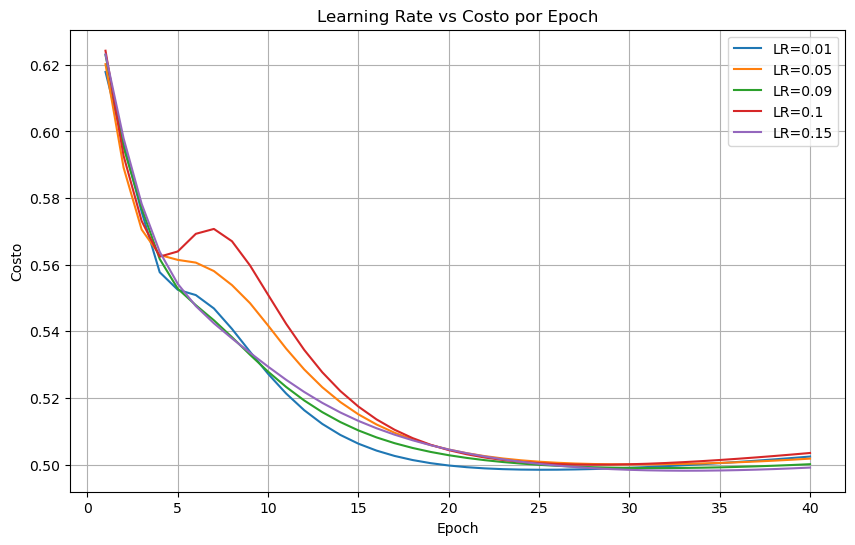

In [17]:
#Graficar los resultados
plt.figure(figsize=(10, 6))
for lr, costs in costs_by_lr.items():
    plt.plot(range(1, len(costs) + 1), costs, label=f'LR={lr}')
plt.title('Learning Rate vs Costo por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Costo')
plt.legend()
plt.grid(True)
plt.show()

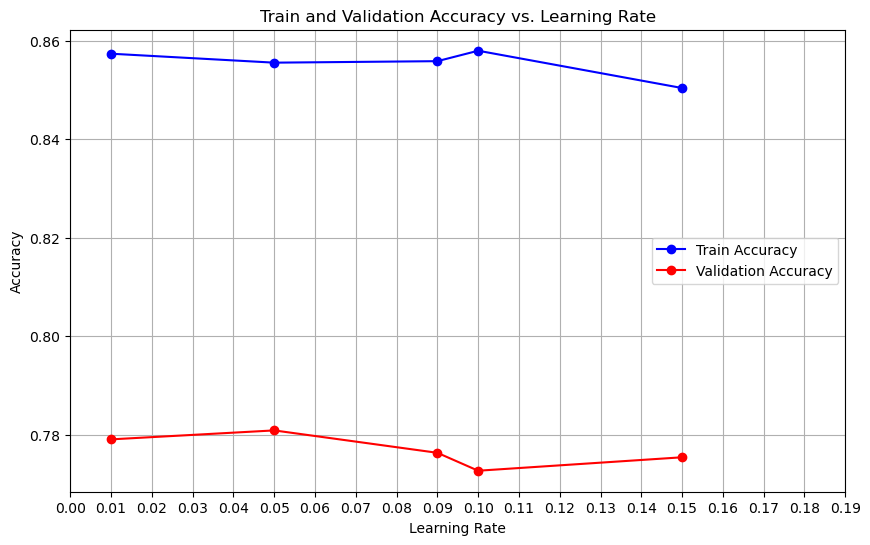

In [18]:
# Gráfica de precisión de entrenamiento y validación vs. learning_rate

# Datos de entrenamiento y validación de precisión para cada learning rate
train_acc_values = [train_acc_by_lr[lr][-1] for lr in learning_rates]
val_acc_values = [val_acc_by_lr[lr][-1] for lr in learning_rates]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_acc_values, marker='o', label='Train Accuracy', linestyle='-', color='b')
plt.plot(learning_rates, val_acc_values, marker='o', label='Validation Accuracy', linestyle='-', color='r')
plt.title('Train and Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 0.2, 0.01))
plt.legend()
plt.grid(True)
plt.show()

### 3.3 Hidden layer number, hidden layer size, activation, early stop and patience

#### Hyperparameter screening

Experiment:
- Hidden layer number from 1 to 3.
- Number of neurons per hidden layer 32 to 256 in jumps of 32.
- Activation function: relu, sigmoid or tanh.
- Early stop activation (on/off) and patience from 7 to 14 in jumps of 7.
- Learning rate fixed to 0.09

##### Running the experiment

In [19]:
models_dict = {}

total_models = 6*3*3*3
current_model = 1

for num_neurons in range(32,193,32):
  models_dict[num_neurons] = {}
  for num_layers in range(1,4):
    models_dict[num_neurons][num_layers] = {}
    for activation in ["relu","sigmoid","tanh"]:
      models_dict[num_neurons][num_layers][activation] = {}

for num_neurons in range(32,193,32):
  for num_layers in range(1,4):
    for activation in ["relu","sigmoid","tanh"]:

      print('\n===============================================================================')
      print('Training Model ',current_model,'/',total_models,'\nHiperparameters: neurons per layer =',num_neurons,'// number of layers = ',num_layers,'// activation = ',activation,'// early_stop = False')
      print('===============================================================================\n')
      current_model = current_model + 1
      models_dict[num_neurons][num_layers][activation][-1] = create_train_model(learning_rate=0.09, num_layers = num_layers, num_neurons = num_neurons, early_stop_active = False, activation_fun=activation)[0]
      
      
      for patience in range(7,15,7):
        print('\n===============================================================================')
        print('Training Model ',current_model,'/',total_models,'\nHiperparameters: neurons per layer =',num_neurons,'// number of layers = ',num_layers,'// activation = ',activation,'// early_stop = True AND patience = ',patience)
        print('===============================================================================\n')

        current_model = current_model + 1
        models_dict[num_neurons][num_layers][activation][patience] = create_train_model(learning_rate=0.09, num_layers = num_layers, num_neurons = num_neurons, early_stop_active = True, patience=patience, activation_fun=activation)[0]



Training Model  1 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  relu // early_stop = False


Training Model  2 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  relu // early_stop = True AND patience =  7


............................
Training Model  3 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  relu // early_stop = True AND patience =  14


................................
Training Model  4 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  sigmoid // early_stop = False


Training Model  5 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  sigmoid // early_stop = True AND patience =  7


..................................
Training Model  6 / 162 
Hiperparameters: neurons per layer = 32 // number of layers =  1 // activation =  sigmoid // early_stop = True AND patience =  14


.......

##### Organizing the results

In [20]:
columns = ['#','# neurons','# layers','early_stopping_patience','optimizer','epochs','train_loss','train_acc','val_loss','val_acc']

experiment_results_summary = pd.DataFrame(columns=columns)

num_exp = 1

for num_neurons_key in models_dict:
  num_layers_dict = models_dict[num_neurons_key]
  for num_layers_key in num_layers_dict:
    activation_dict = num_layers_dict[num_layers_key]
    for activation_dict_key in activation_dict:
      early_stop_dict = activation_dict[activation_dict_key]
      for early_stop_key in early_stop_dict:

        print('num neurons key: ' , num_neurons_key)
        print('num layers key: ' , num_layers_key)
        print('activation dict key: ' , activation_dict_key)
        print('early stop key: ' , early_stop_key)
        history = models_dict[num_neurons_key][num_layers_key][activation_dict_key][early_stop_key]
        

        print('history: ' , history)

        new_row = {
            '#':num_exp,
            '# neurons':num_neurons_key,
            '# layers':num_layers_key,
            'early_stopping_patience': early_stop_key,
            'optimizer' : activation_dict_key,
            'epochs' : history.epoch[-1] + 1,            
            'train_loss' : np.sqrt(history.history['loss'][-1]),
            'train_acc' : history.history['accuracy'][-1],
            'val_loss' : np.sqrt(history.history['val_loss'][-1]),
            'val_acc' : history.history['val_accuracy'][-1]        
        }
        new_row_df = pd.DataFrame(new_row, index = [0])
        experiment_results_summary = pd.concat([experiment_results_summary, new_row_df],ignore_index=True)
        num_exp += 1


experiment_results_summary

num neurons key:  32
num layers key:  1
activation dict key:  relu
early stop key:  -1
history:  <keras.src.callbacks.History object at 0x7f79a42ca340>
num neurons key:  32
num layers key:  1
activation dict key:  relu
early stop key:  7
history:  <keras.src.callbacks.History object at 0x7f79a41e7a30>
num neurons key:  32
num layers key:  1
activation dict key:  relu
early stop key:  14
history:  <keras.src.callbacks.History object at 0x7f79a4084040>
num neurons key:  32
num layers key:  1
activation dict key:  sigmoid
early stop key:  -1
history:  <keras.src.callbacks.History object at 0x7f798c1510d0>
num neurons key:  32
num layers key:  1
activation dict key:  sigmoid
early stop key:  7
history:  <keras.src.callbacks.History object at 0x7f798c0aca60>
num neurons key:  32
num layers key:  1
activation dict key:  sigmoid
early stop key:  14
history:  <keras.src.callbacks.History object at 0x7f798c094c10>
num neurons key:  32
num layers key:  1
activation dict key:  tanh
early stop key

,#,# neurons,# layers,early_stopping_patience,optimizer,epochs,train_loss,train_acc,val_loss,val_acc
0,1,32,1,-1,relu,40,0.614769,0.841611,0.751849,0.735455
1,2,32,1,7,relu,28,0.612575,0.841005,0.768054,0.723636
2,3,32,1,14,relu,32,0.606304,0.846457,0.718489,0.765455
3,4,32,1,-1,sigmoid,40,0.599181,0.855845,0.71184,0.765455
4,5,32,1,7,sigmoid,34,0.611437,0.847365,0.709857,0.767273
...,...,...,...,...,...,...,...,...,...,...
157,158,192,3,7,sigmoid,40,0.741806,0.727741,0.756836,0.704545
158,159,192,3,14,sigmoid,40,0.732416,0.74046,0.752358,0.714545
159,160,192,3,-1,tanh,40,0.498668,0.905815,0.731554,0.78
160,161,192,3,7,tanh,9,0.683467,0.788613,0.812873,0.695455


##### Retrieving the best result

In [21]:
experiment_results_summary_sorted = experiment_results_summary.sort_values(by='val_acc',ascending=False)

experiment_results_summary_sorted

,#,# neurons,# layers,early_stopping_patience,optimizer,epochs,train_loss,train_acc,val_loss,val_acc
87,88,128,1,-1,tanh,40,0.466372,0.929134,0.713733,0.788182
42,43,64,2,-1,tanh,40,0.547873,0.877953,0.735929,0.786364
74,75,96,3,14,relu,26,0.586194,0.857056,0.721755,0.784545
54,55,96,1,-1,relu,40,0.535434,0.88613,0.733529,0.784545
144,145,192,2,-1,relu,40,0.555408,0.882193,0.715571,0.784545
...,...,...,...,...,...,...,...,...,...,...
133,134,160,3,7,tanh,9,0.681803,0.791641,0.87695,0.645455
154,155,192,3,7,relu,21,0.634379,0.825863,0.807538,0.634545
25,26,32,3,7,tanh,19,0.700671,0.774682,0.812884,0.626364
83,84,128,1,14,relu,30,0.590459,0.853725,0.896644,0.607273


In [22]:
#idx = experiment_results_summary_sorted['val_acc'].idxmax()
#best_model_hyperparameters = experiment_results_summary.iloc[idx]

best_model = experiment_results_summary_sorted.iloc[0, :]
best_model

#                                88
# neurons                       128
# layers                          1
early_stopping_patience          -1
optimizer                      tanh
epochs                           40
train_loss                 0.466372
train_acc                  0.929134
val_loss                   0.713733
val_acc                    0.788182
Name: 87, dtype: object

### 3.4 Best model evaluation and sample predictions

#### Evaluation

##### Retraining

In [23]:
layers = best_model['# layers']
neurons = best_model['# neurons']
early_stop = False if best_model['early_stopping_patience'] == -1 else True
patience = best_model['early_stopping_patience']
activation = best_model['optimizer']

best_model_history,best_model = create_train_model(num_layers=layers , num_neurons=neurons, early_stop_active = early_stop, patience=patience, activation_fun=activation, verbose=1)

Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_504 (Dense)           (None, 128)               3840128   
                                                                 
 dense_505 (Dense)           (None, 1)                 129       
                                                                 
Total params: 3840257 (14.65 MB)
Trainable params: 3840257 (14.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
104/104 [==============================] - 1s 10ms/step - loss: 0.8093 - accuracy: 0.5815 - val_loss: 0.6657 - val_accuracy: 0.5618
Epoch 2/40
104/104 [==============================] - 1s 8ms/step - loss: 0.6479 - accuracy: 0.6187 - val_loss: 0.6379 - val_accuracy: 0.6509
Epoch 3/40
104/104 [==============================] - 1s 8ms/step - loss: 0.6186 - accuracy: 0.6632 - val_loss: 0.6424 - va

##### Accuracy and loss vs. epochs

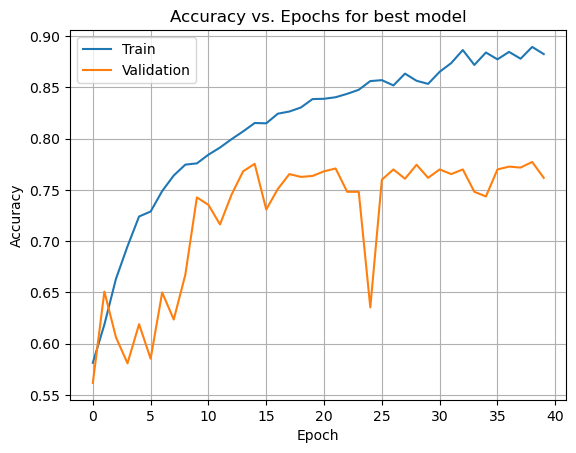

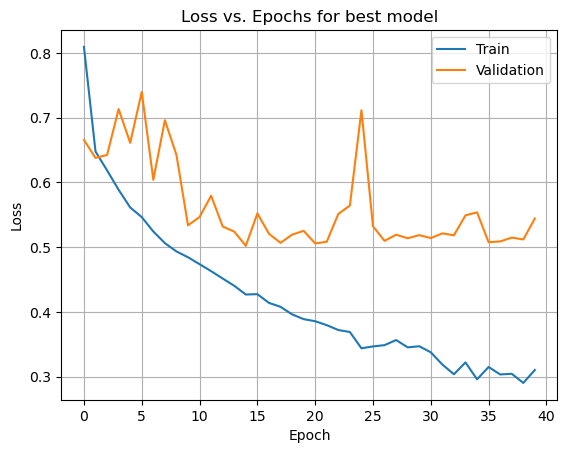

In [24]:
epochs = best_model_history.epoch
train_acc_history_best = best_model_history.history['accuracy']
val_acc_history_best = best_model_history.history['val_accuracy']
train_loss_history_best = best_model_history.history['loss']
val_loss_history_best = best_model_history.history['val_loss']


graph(epochs,[train_acc_history_best,val_acc_history_best],['Train','Validation'],'Epoch','Accuracy','Accuracy vs. Epochs for best model')
graph(epochs,[train_loss_history_best,val_loss_history_best],['Train','Validation'],'Epoch','Loss','Loss vs. Epochs for best model')

##### Evaluation against test data

In [25]:
best_model_eval_metrics = best_model.evaluate(x=test_set_x,y=test_set_y, verbose=0)

print("Test loss: ", best_model_eval_metrics[0])
print("Test accuracy: ", best_model_eval_metrics[1])

Test loss:  0.5446378588676453
Test accuracy:  0.7675401568412781


#### Prediction

1/1 [==============================] - 0s 60ms/step
PRED: Its a [[[0.9145353]]] muffin
REAL: Its a [1] muffin


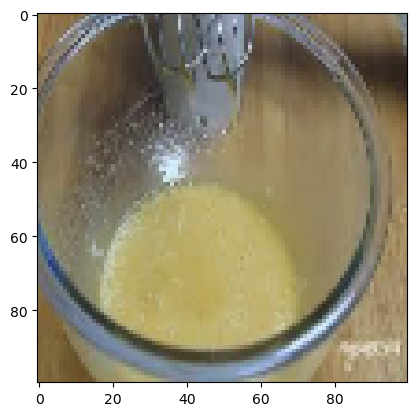

In [26]:
#Gets a random batch from the train set
sample_image = test_set.as_numpy_iterator().next()

#Extracts data and label
data = sample_image[0][15]
label = sample_image[1][15]

#Gets image shape
image_shape = data.shape

# Reshapes, flatten and normalizes image
data2 = data.reshape((1,image_shape[0],image_shape[1],image_shape[2]))
data_normalized_flattened = flatten_and_normalize_image_data(data2).T
data_normalized_flattened.shape

#Predicts label
prediction = best_model.predict(data_normalized_flattened)

#Prints prediction and real label
print("PRED: Its a", '['+str(prediction)+']', 'muffin' if prediction>0.5 else 'chihuahua')
print("REAL: Its a", '['+str(label)+']', 'muffin' if label==1 else 'chihuahua')

plt.imshow(data.astype(int))

Dropout, regularización y aumentación